# Diabetes Prediction Using Machine Learning

This notebook aims to build and evaluate machine learning models to predict the likelihood of diabetes. The analysis includes data cleaning, feature selection, model comparison, and model interpretability using SHAP.


## Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, accuracy_score, mean_squared_error, r2_score, roc_auc_score, auc, roc_curve, classification_report, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")
%matplotlib inline

## Load and Inspect the Dataset


In [ ]:
# Google Drive shareable file link
file_id = '1ilqVTpvOpIODKGglU23zahqs7Y4HxMfH'
url = f'https://drive.google.com/uc?id={file_id}'

# Read CSV file directly from the URL
df = pd.read_csv(url)

# Preview the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


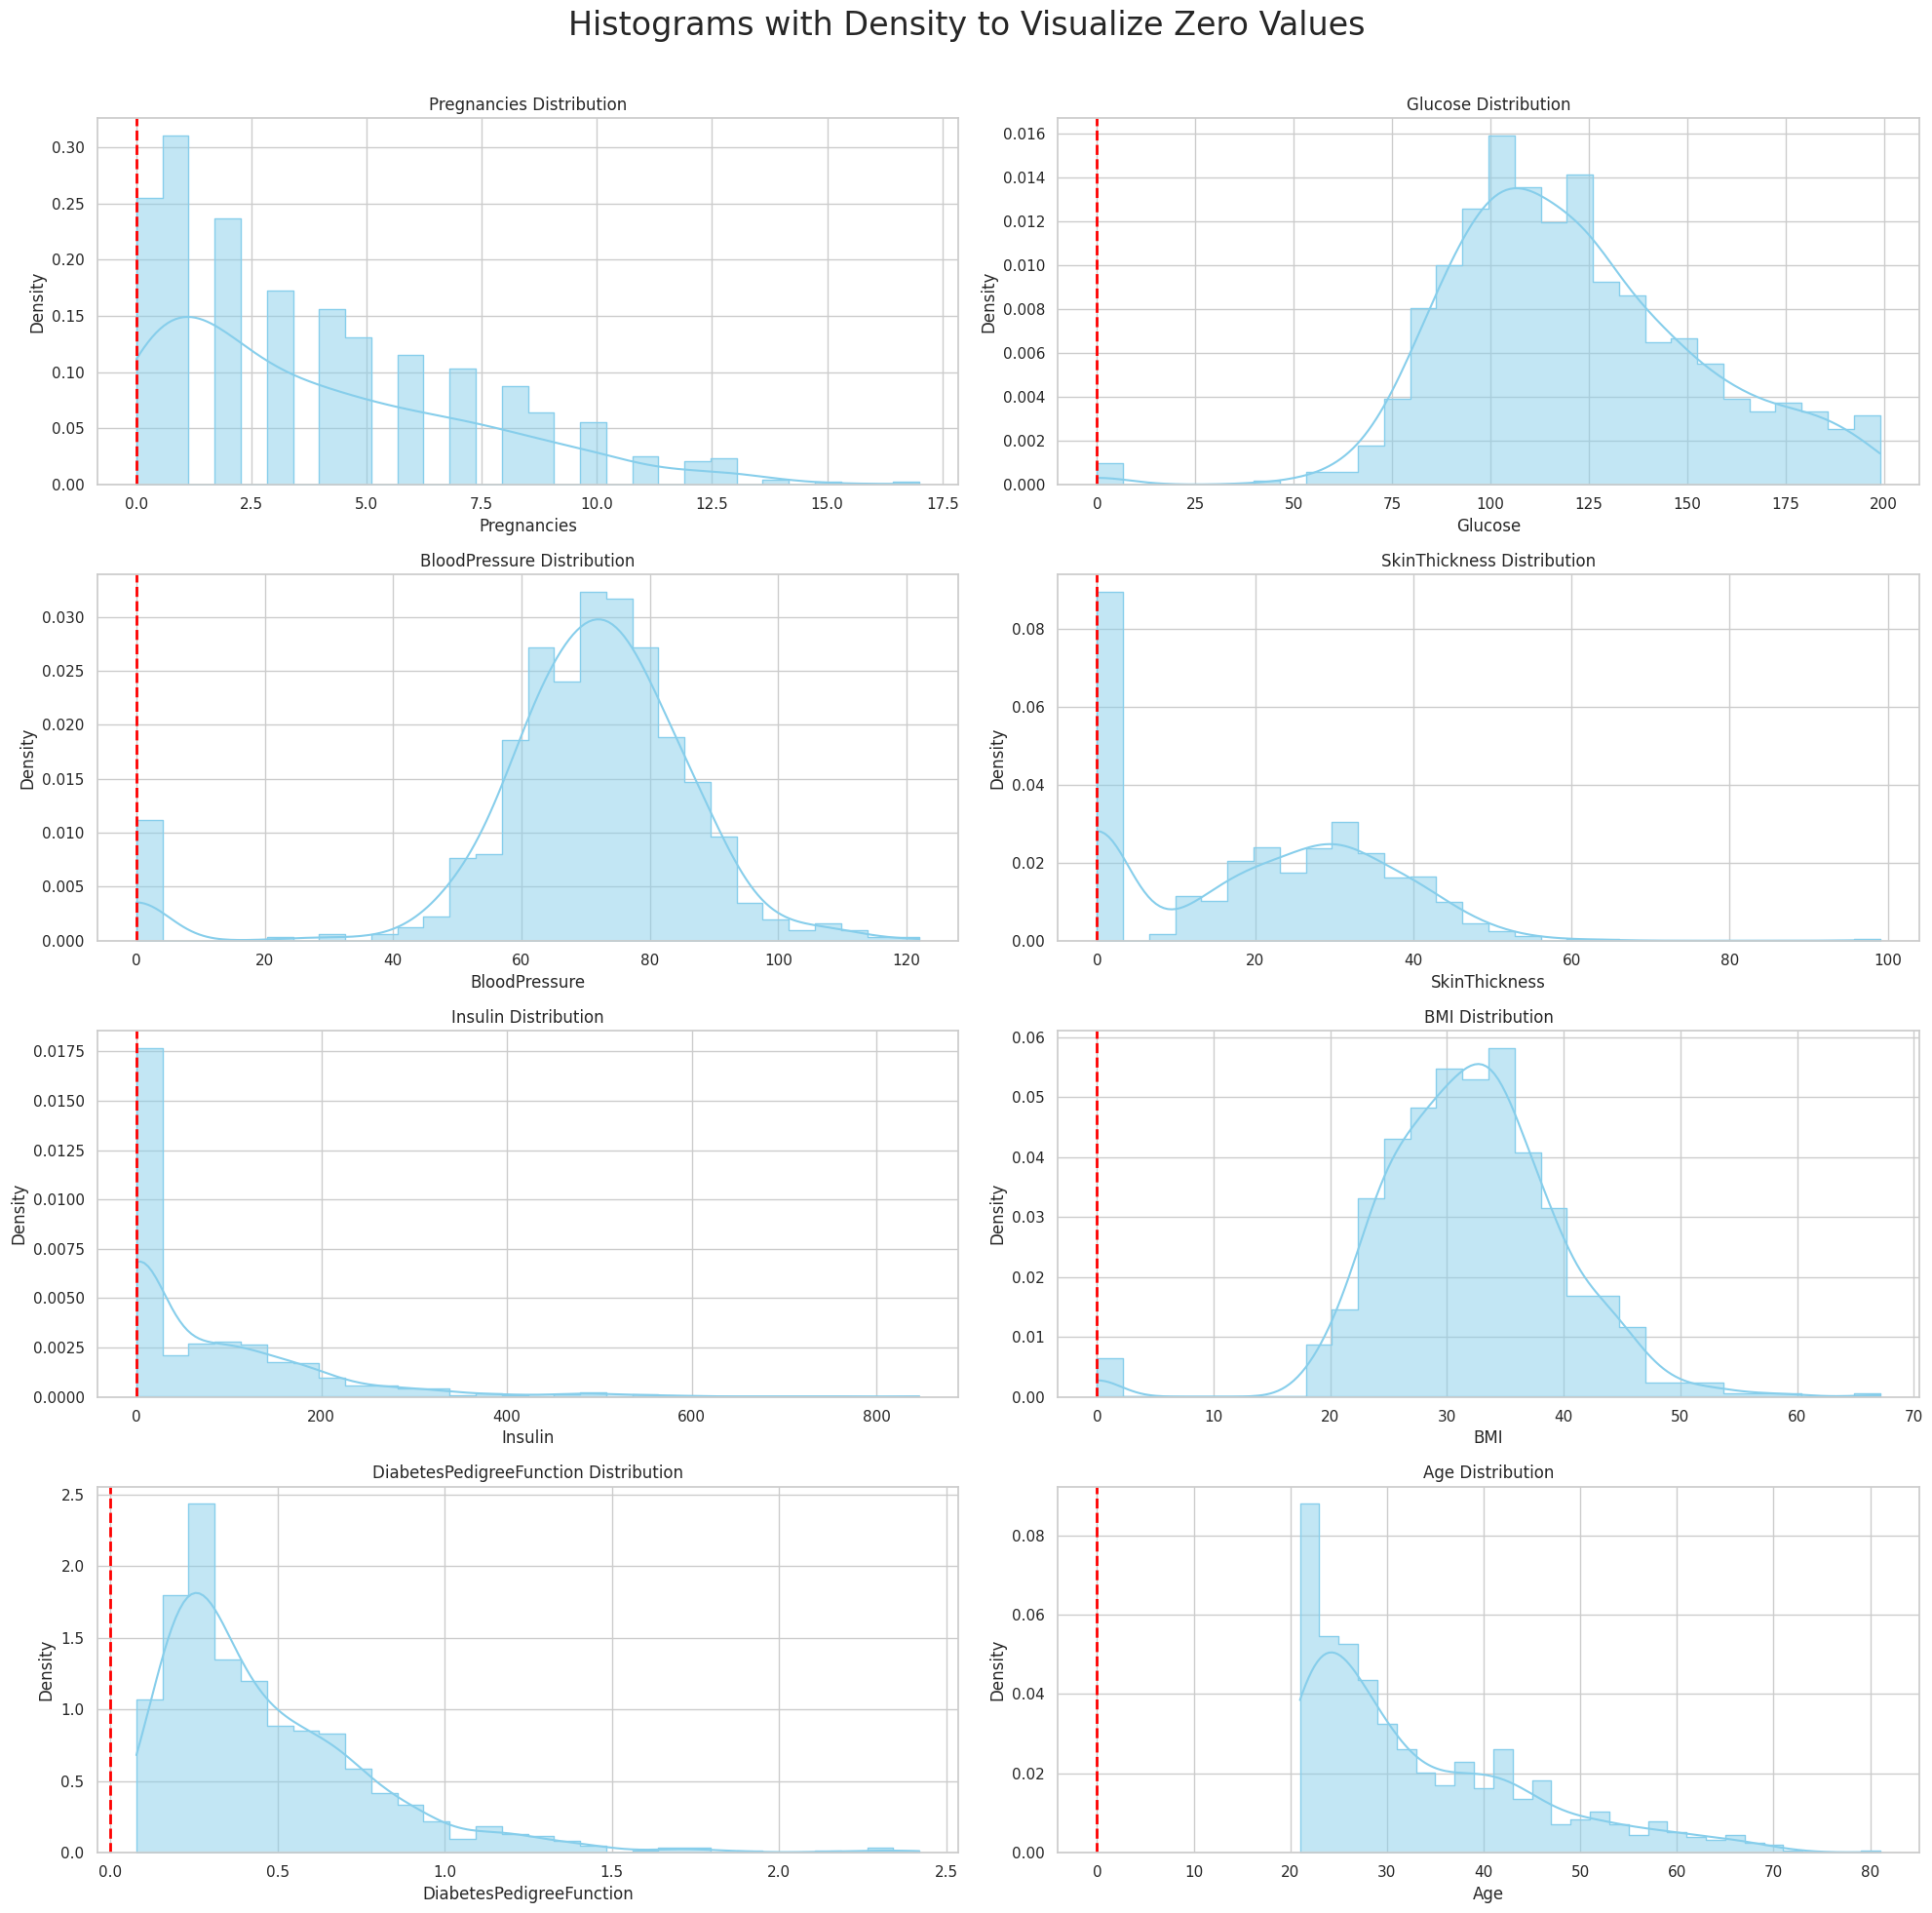

In [ ]:
# Set visual style
sns.set(style="whitegrid")

# Create subplots for all features except 'Outcome'
features = [col for col in df.columns if col != 'Outcome']
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Histograms with Density to Visualize Zero Values', fontsize=24)
axes = ax.flatten()

# Plot each feature
for i, col in enumerate(features):
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        bins=30,
        color='skyblue',
        stat='density',
        element='step',
        ax=axes[i]
    )
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Remove unused subplot if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Data Cleaning and Preprocessing

### Replace Invalid Zero Values with NaN
Some features like Glucose or BMI cannot be 0 — we will treat them as missing values.


In [ ]:
# Columns where 0 is not a valid value
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Check missing values introduced
df.isnull().sum()


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0
AgeGroup,0


### Impute Missing Values Using Median
We will use the median since it is more robust to outliers.


In [ ]:
# Impute missing values with median of each column
df.fillna(df.median(numeric_only=True), inplace=True)

# Confirm no missing values remain
df.isnull().sum()


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0
AgeGroup,0


## Remove Outliers in SkinThickness
SkinThickness values over 90 may me considered implausible and will be removed.

In [ ]:
# Remove rows where SkinThickness is greater than 90 (likely invalid)
df = df[df['SkinThickness'] <= 90]

# Confirm max value is now acceptable
print("Max SkinThickness after cleaning:", df['SkinThickness'].max())


Max SkinThickness after cleaning: 63.0


### Convert Outcome Column to Categorical
This helps treat the Outcome properly in plots and models.

In [ ]:
df['Outcome'] = df['Outcome'].astype('category')

### Confirm Cleaning
Let’s inspect the final structure and summary stats of our cleaned dataset.

In [ ]:
# Check structure and stats
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 767 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               767 non-null    int64   
 1   Glucose                   767 non-null    float64 
 2   BloodPressure             767 non-null    float64 
 3   SkinThickness             767 non-null    float64 
 4   Insulin                   767 non-null    float64 
 5   BMI                       767 non-null    float64 
 6   DiabetesPedigreeFunction  767 non-null    float64 
 7   Age                       767 non-null    int64   
 8   Outcome                   767 non-null    category
dtypes: category(1), float64(6), int64(2)
memory usage: 54.8 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.847458,121.558018,72.389831,29.016949,140.692308,32.452282,0.471742,33.203390
std,3.371117,30.336089,12.104228,8.426210,86.437570,6.879184,0.331524,11.721879
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.500000,64.000000,25.000000,121.000000,27.500000,0.243500,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.371000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.626500,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


## Enhanced Exploratory Data Analysis (EDA)


### Outcome class balance
Check for outcome distribution.

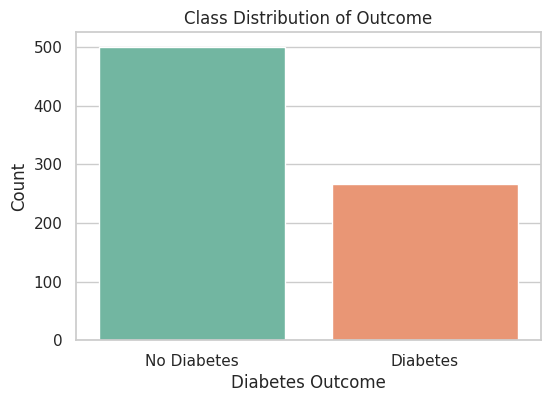

Outcome
0    0.65189
1    0.34811
Name: proportion, dtype: float64


In [ ]:
# === Outcome class balance (again, as a plot) ===
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Class Distribution of Outcome')
plt.xlabel('Diabetes Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.show()

# Check class distribution
print(df['Outcome'].value_counts(normalize=True))


### Histograms Differentiated by Diabetes Outcome
These histograms show how each feature distribution varies between diabetic and non-diabetic patients.

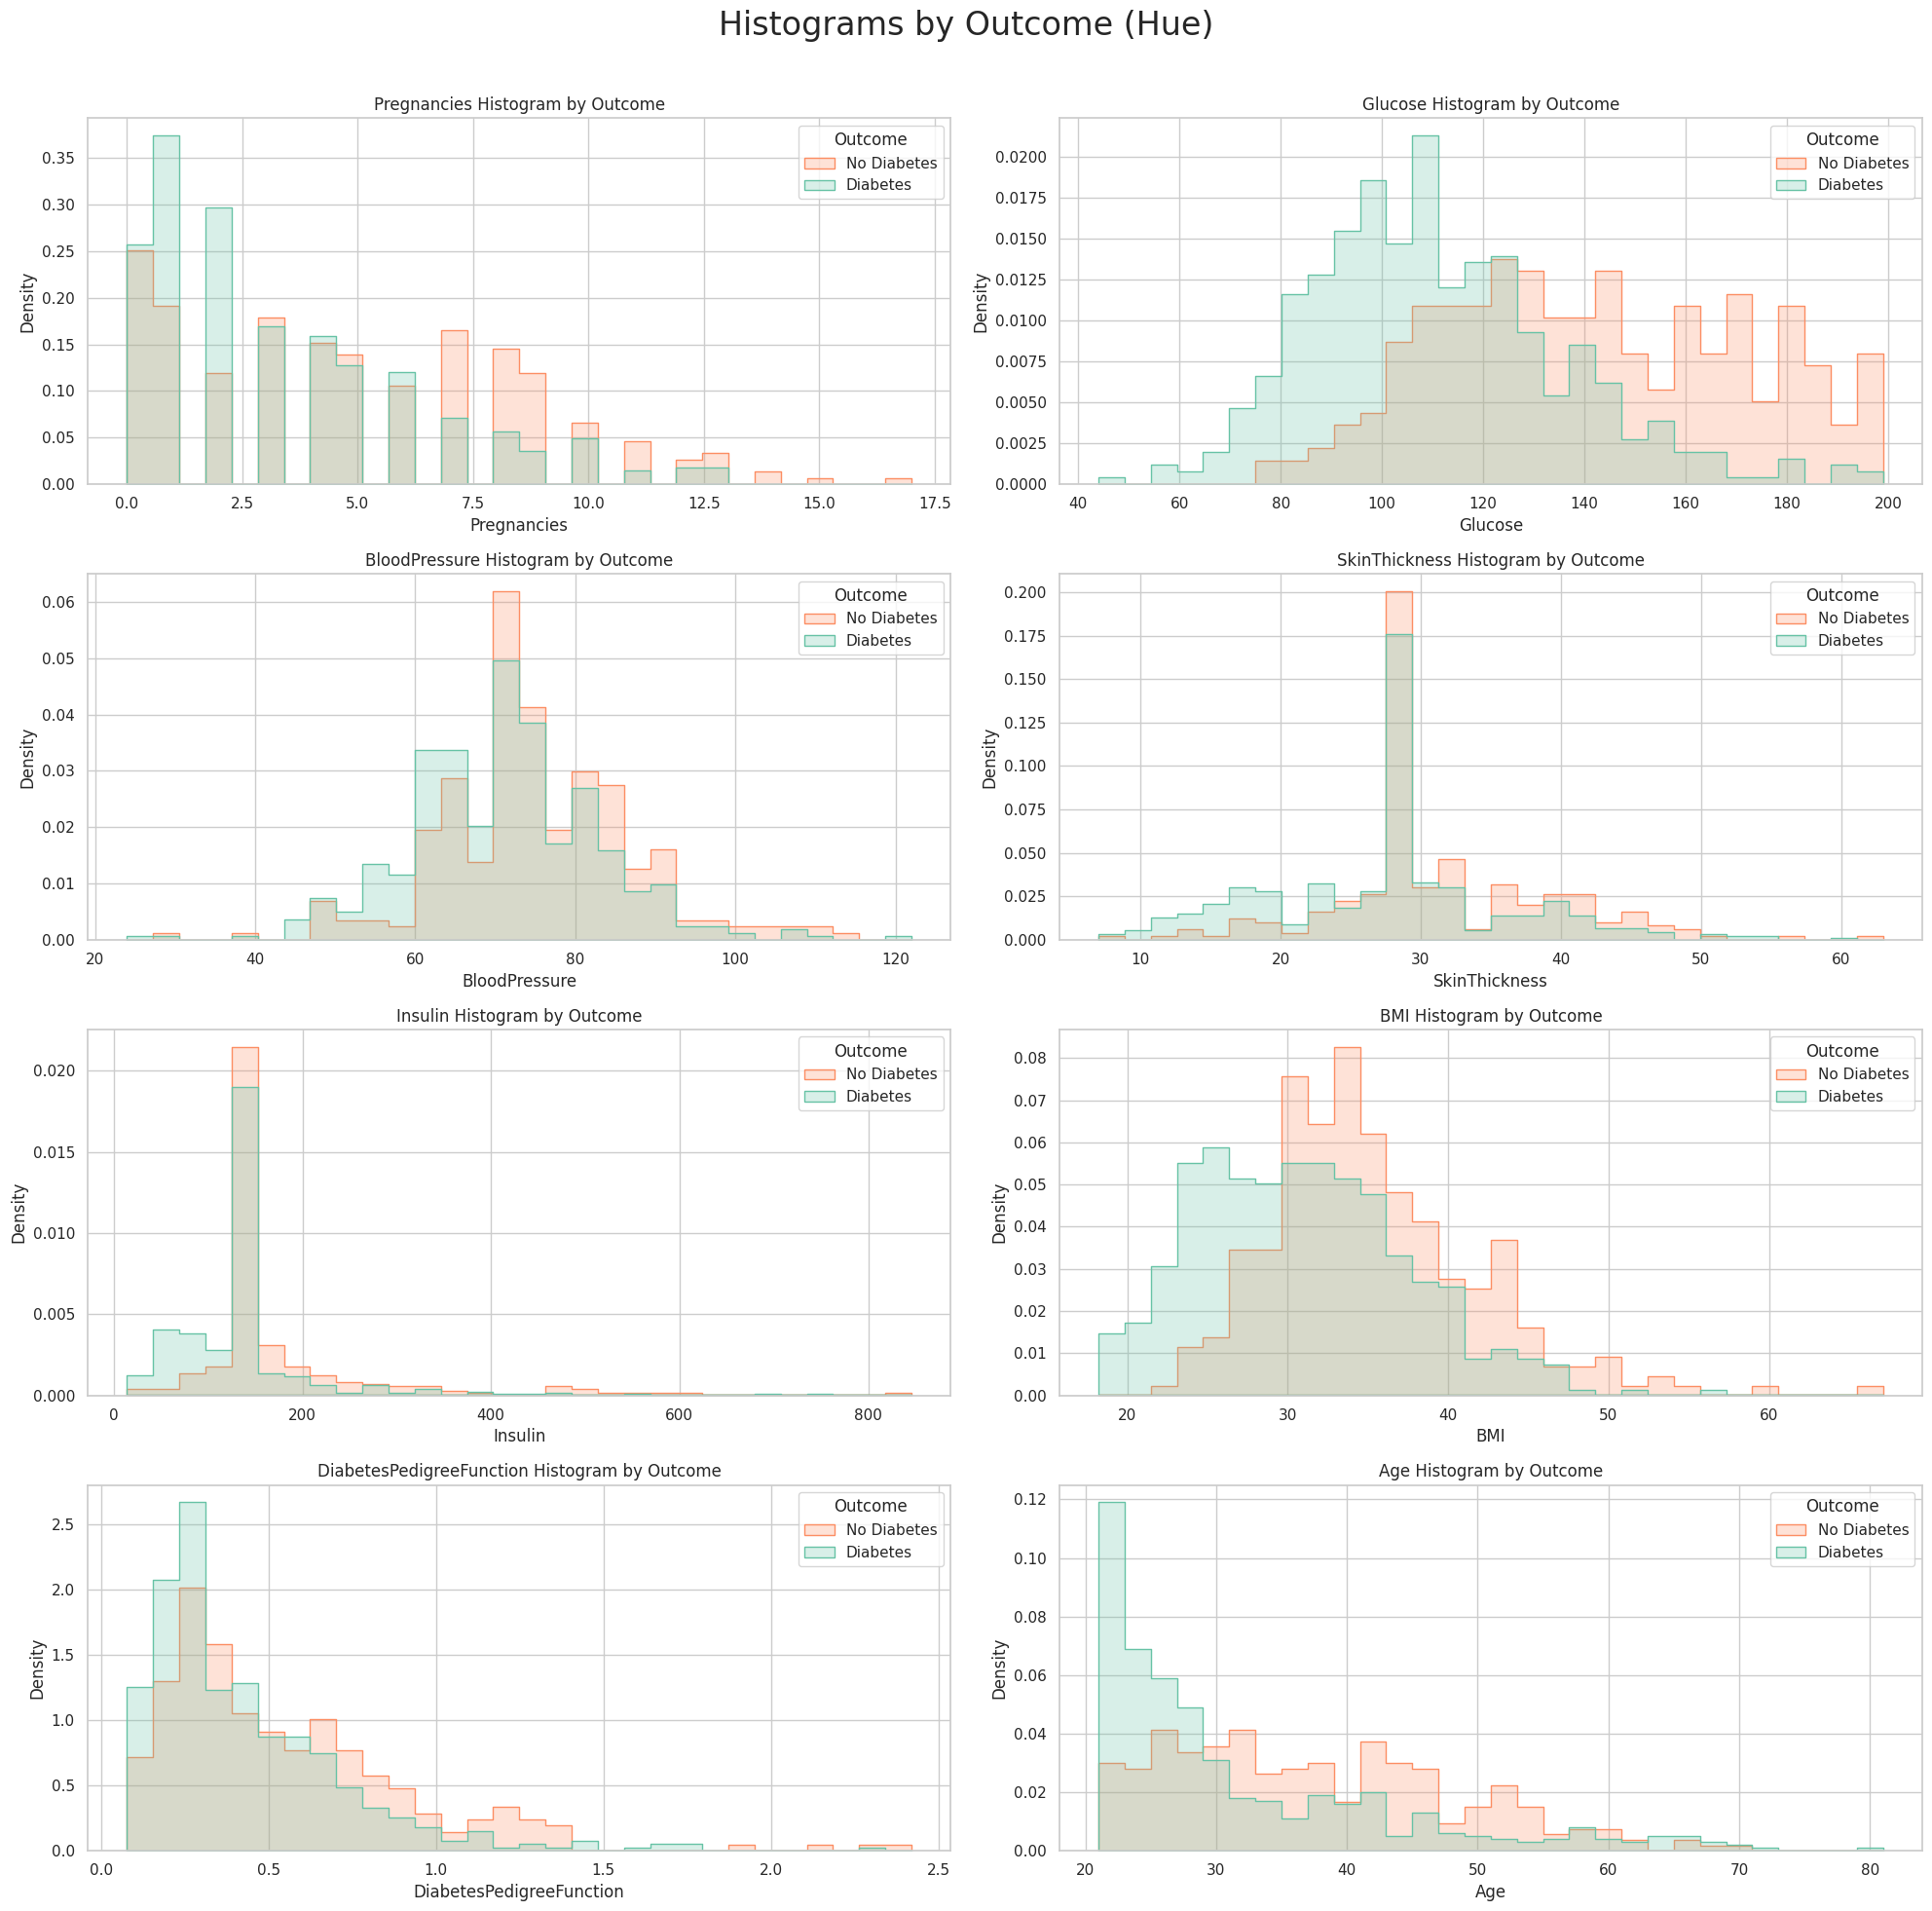

In [ ]:
# Histograms by outcome
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Histograms by Outcome (Hue)', fontsize=24)
axes = ax.flatten()

for i, column in enumerate(df.columns):
    if column != 'Outcome':
        sns.histplot(
            data=df,
            x=column,
            hue='Outcome',
            kde=False,
            bins=30,
            palette='Set2',
            element='step',
            stat='density',
            common_norm=False,
            ax=axes[i]
        )
        axes[i].set_title(f'{column} Histogram by Outcome')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')
        axes[i].legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### Correlation Heatmap
This heatmap shows how strongly each feature is linearly related to the others. Strong correlations can suggest feature redundancy.


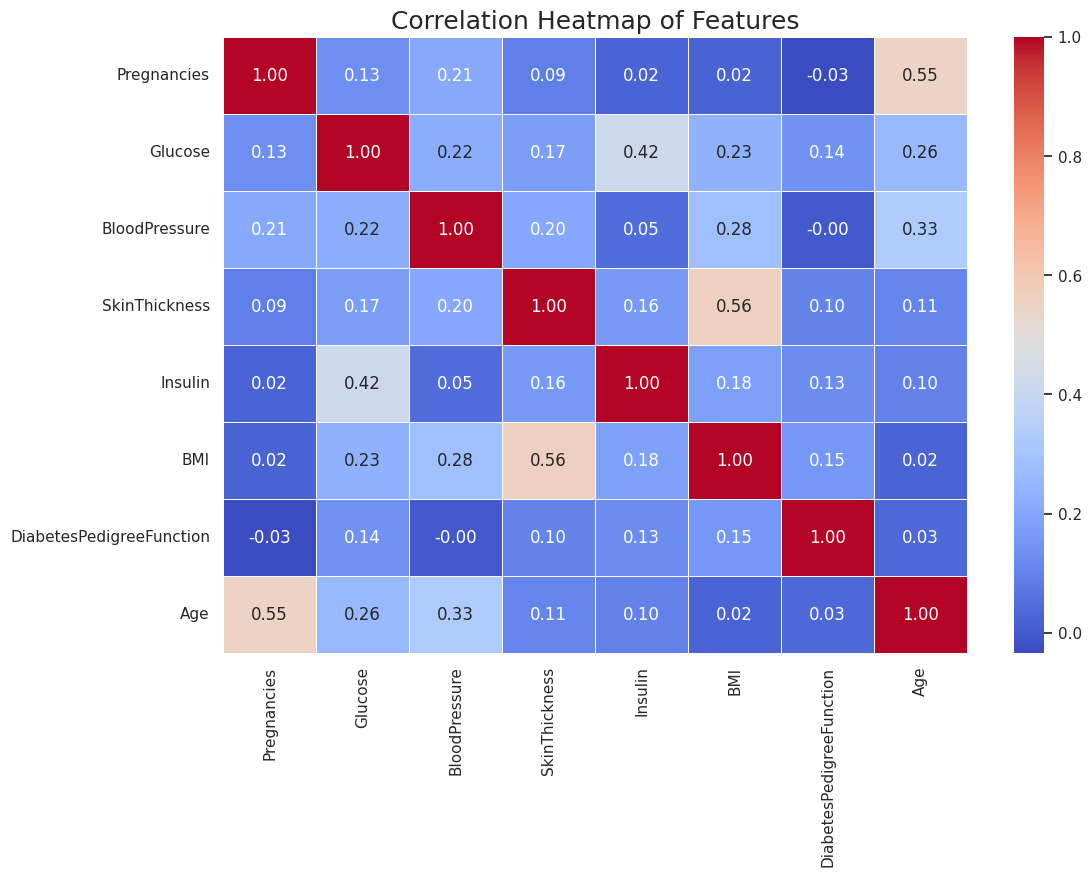

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=18)
plt.show()


### Boxplots by Outcome
Boxplots reveal the spread, median, and potential outliers in feature distributions, grouped by diabetes outcome.


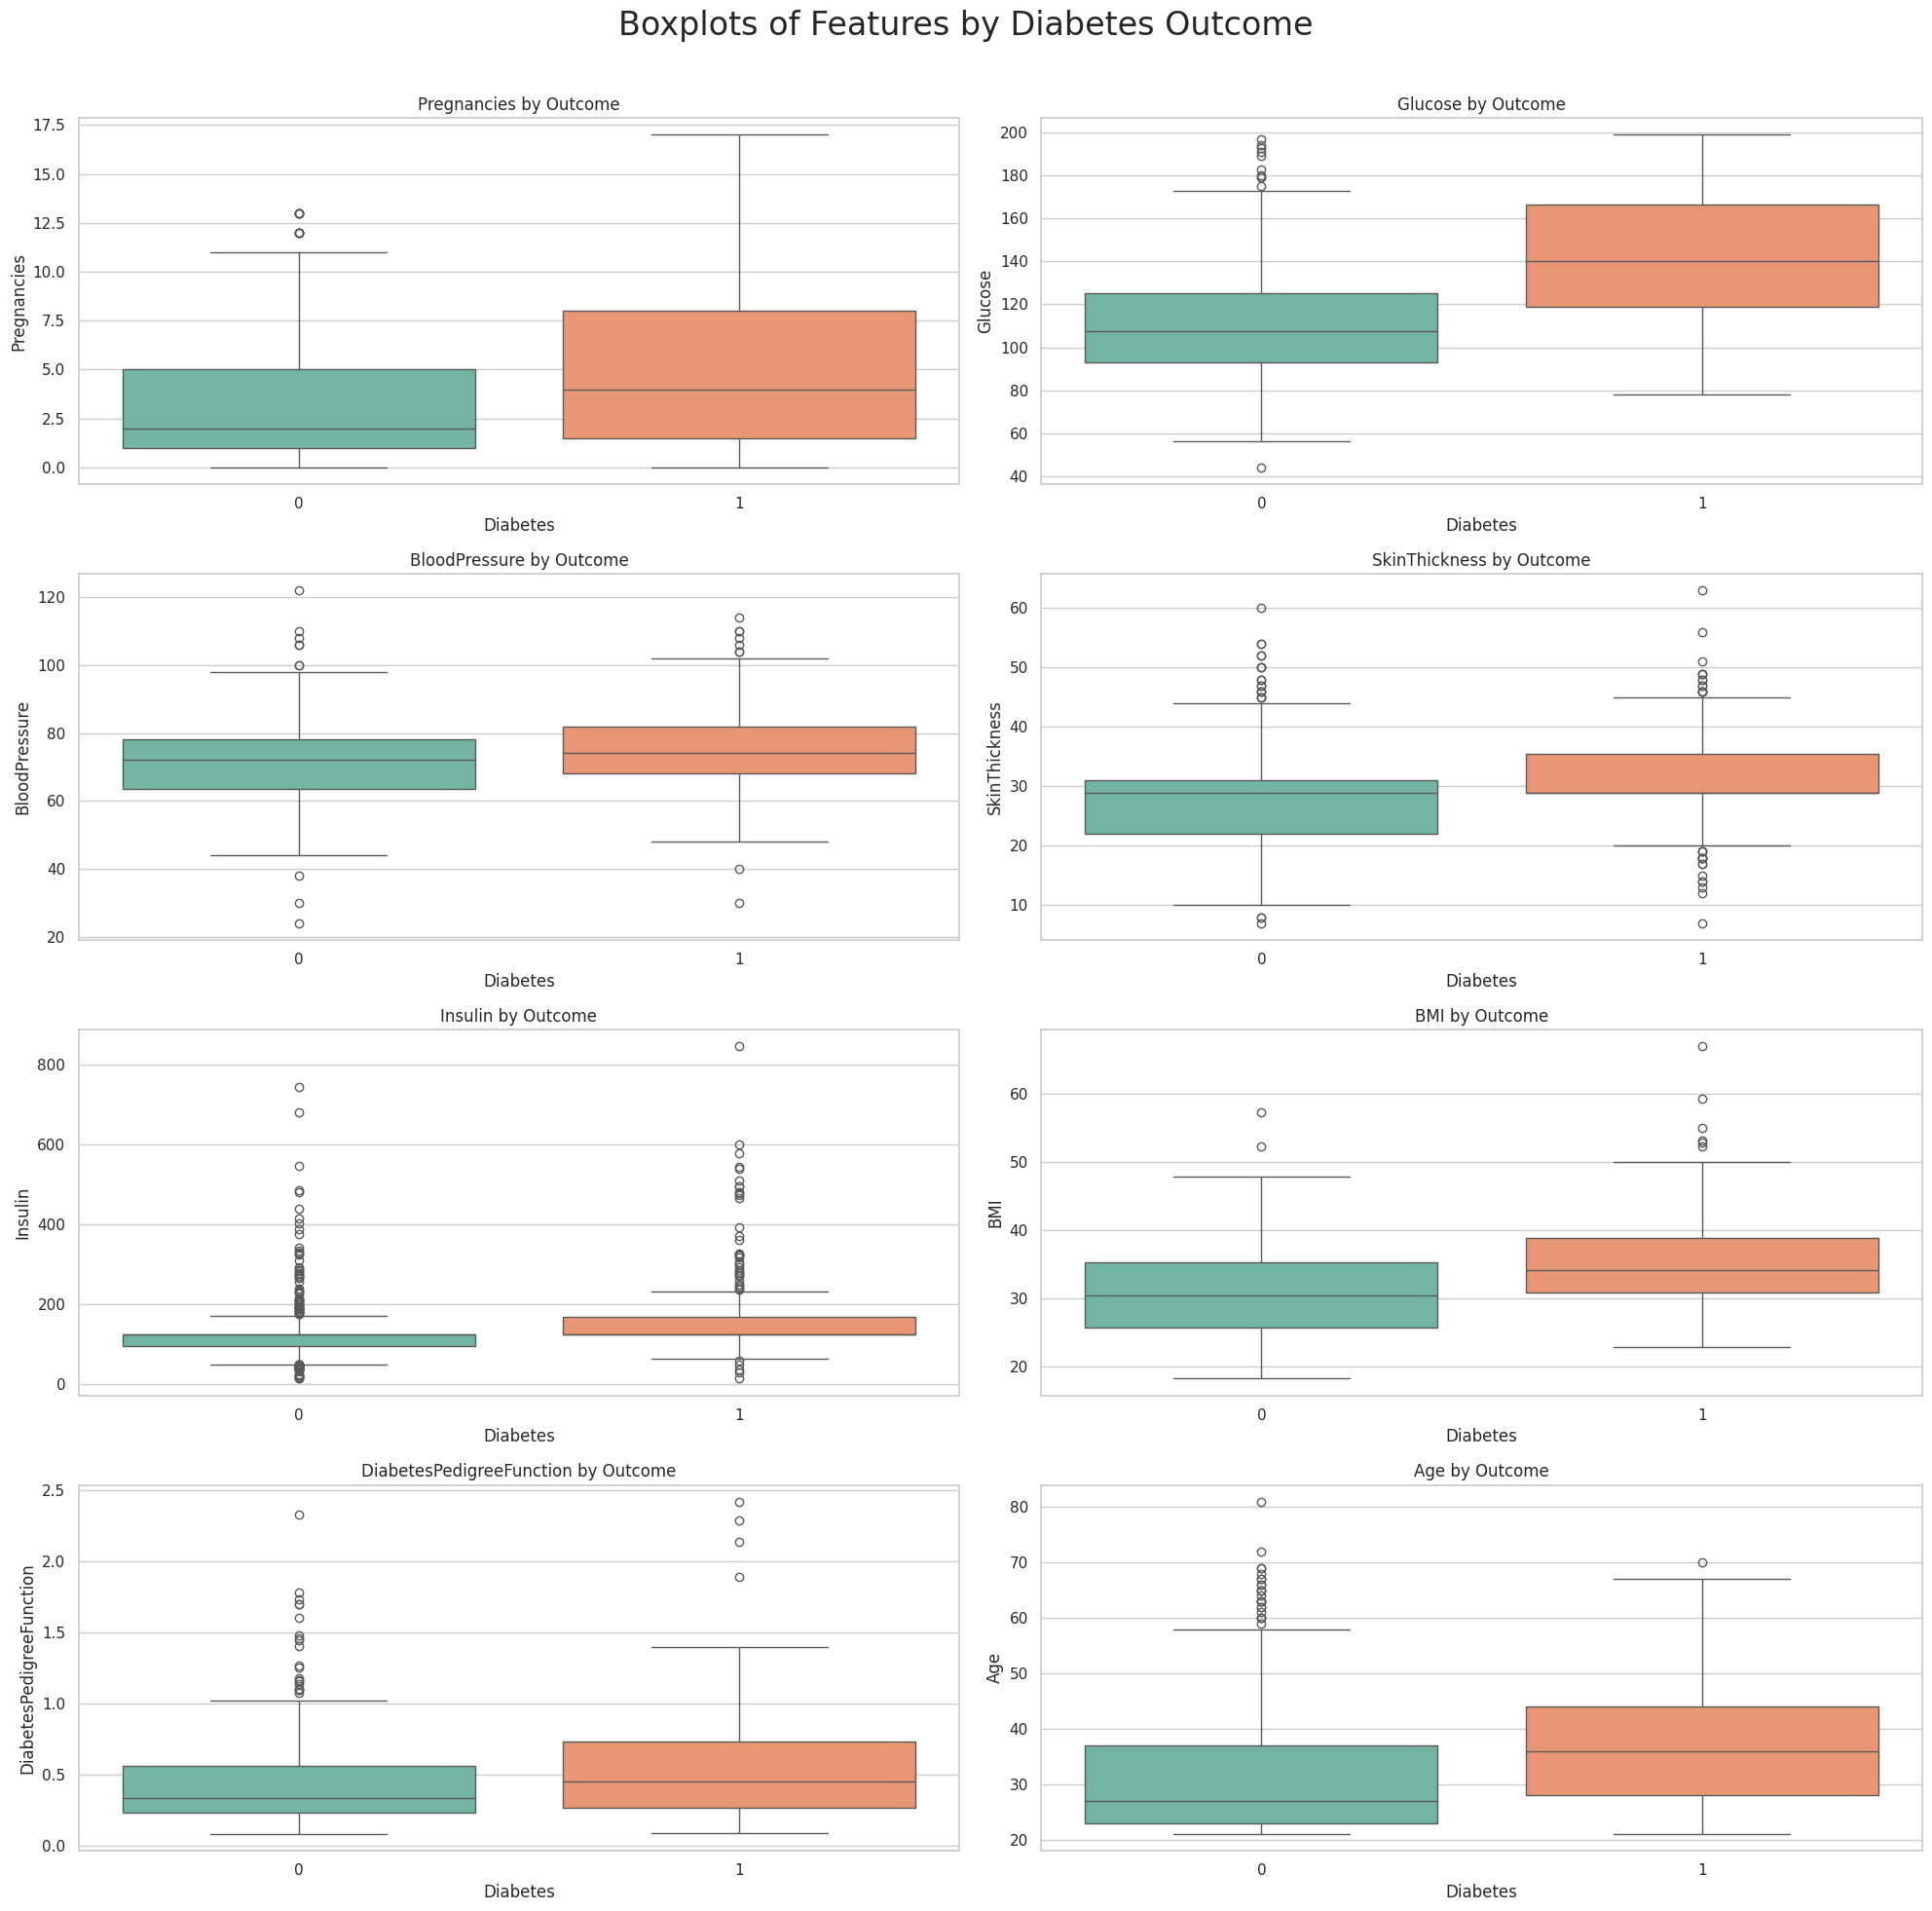

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Boxplots of Features by Diabetes Outcome', fontsize=24)
axes = ax.flatten()

for i, column in enumerate(df.columns):
    if column != 'Outcome':
        sns.boxplot(data=df, x='Outcome', y=column, palette='Set2', ax=axes[i])
        axes[i].set_title(f'{column} by Outcome')
        axes[i].set_xlabel('Diabetes')
        axes[i].set_ylabel(column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Feature Engineering
We enhance the dataset with derived features that may improve model performance.


In [ ]:
# Age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 100],
                        labels=['21-30', '31-40', '41-50', '51-60', '61+'])

# BMI categories
df['BMICategory'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Binary pregnancy indicator
df['HasPregnancies'] = (df['Pregnancies'] > 0).astype(int)

df['PregnancyGroup'] = pd.cut(df['Pregnancies'], bins=[-1, 0, 2, 5, 10, 20],
                              labels=['0', '1-2', '3-5', '6-10', '11+'])
df['GlucoseLevel'] = pd.cut(df['Glucose'], bins=[0, 99, 125, 200],
                            labels=['Normal', 'Prediabetic', 'Diabetic'])
df['InsulinLevel'] = pd.cut(df['Insulin'], bins=[0, 100, 200, 900],
                            labels=['Low', 'Medium', 'High'])
df['BloodPressureGroup'] = pd.cut(df['BloodPressure'], bins=[0, 80, 89, 200],
                                  labels=['Normal', 'Elevated', 'High'])



### Encoding Engineered Categorical Features
We will use one-hot encoding for all multi-class features. HasPregnancies is already binary.


In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'AgeGroup',
       'BMICategory', 'HasPregnancies', 'PregnancyGroup', 'GlucoseLevel',
       'InsulinLevel', 'BloodPressureGroup'],
      dtype='object')

In [ ]:
# Features to encode
features_to_encode = ['AgeGroup', 'BMICategory', 'PregnancyGroup',
                      'GlucoseLevel', 'InsulinLevel', 'BloodPressureGroup']

# One-hot encode
df_encoded = pd.get_dummies(df, columns=features_to_encode, drop_first=True)

# Check shape and preview
print("Shape after encoding:", df_encoded.shape)
df_encoded.head()


Shape after encoding: (767, 27)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HasPregnancies,...,PregnancyGroup_1-2,PregnancyGroup_3-5,PregnancyGroup_6-10,PregnancyGroup_11+,GlucoseLevel_Prediabetic,GlucoseLevel_Diabetic,InsulinLevel_Medium,InsulinLevel_High,BloodPressureGroup_Elevated,BloodPressureGroup_High
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,1,...,False,False,True,False,False,True,True,False,False,False
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,1,...,True,False,False,False,False,False,True,False,False,False
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,1,...,False,False,True,False,False,True,True,False,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,...,True,False,False,False,False,False,False,False,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,...,False,False,False,False,False,True,True,False,False,False


### Visualizing Engineered Features by Outcome
This grid shows how each engineered categorical feature varies between diabetic and non-diabetic patients.


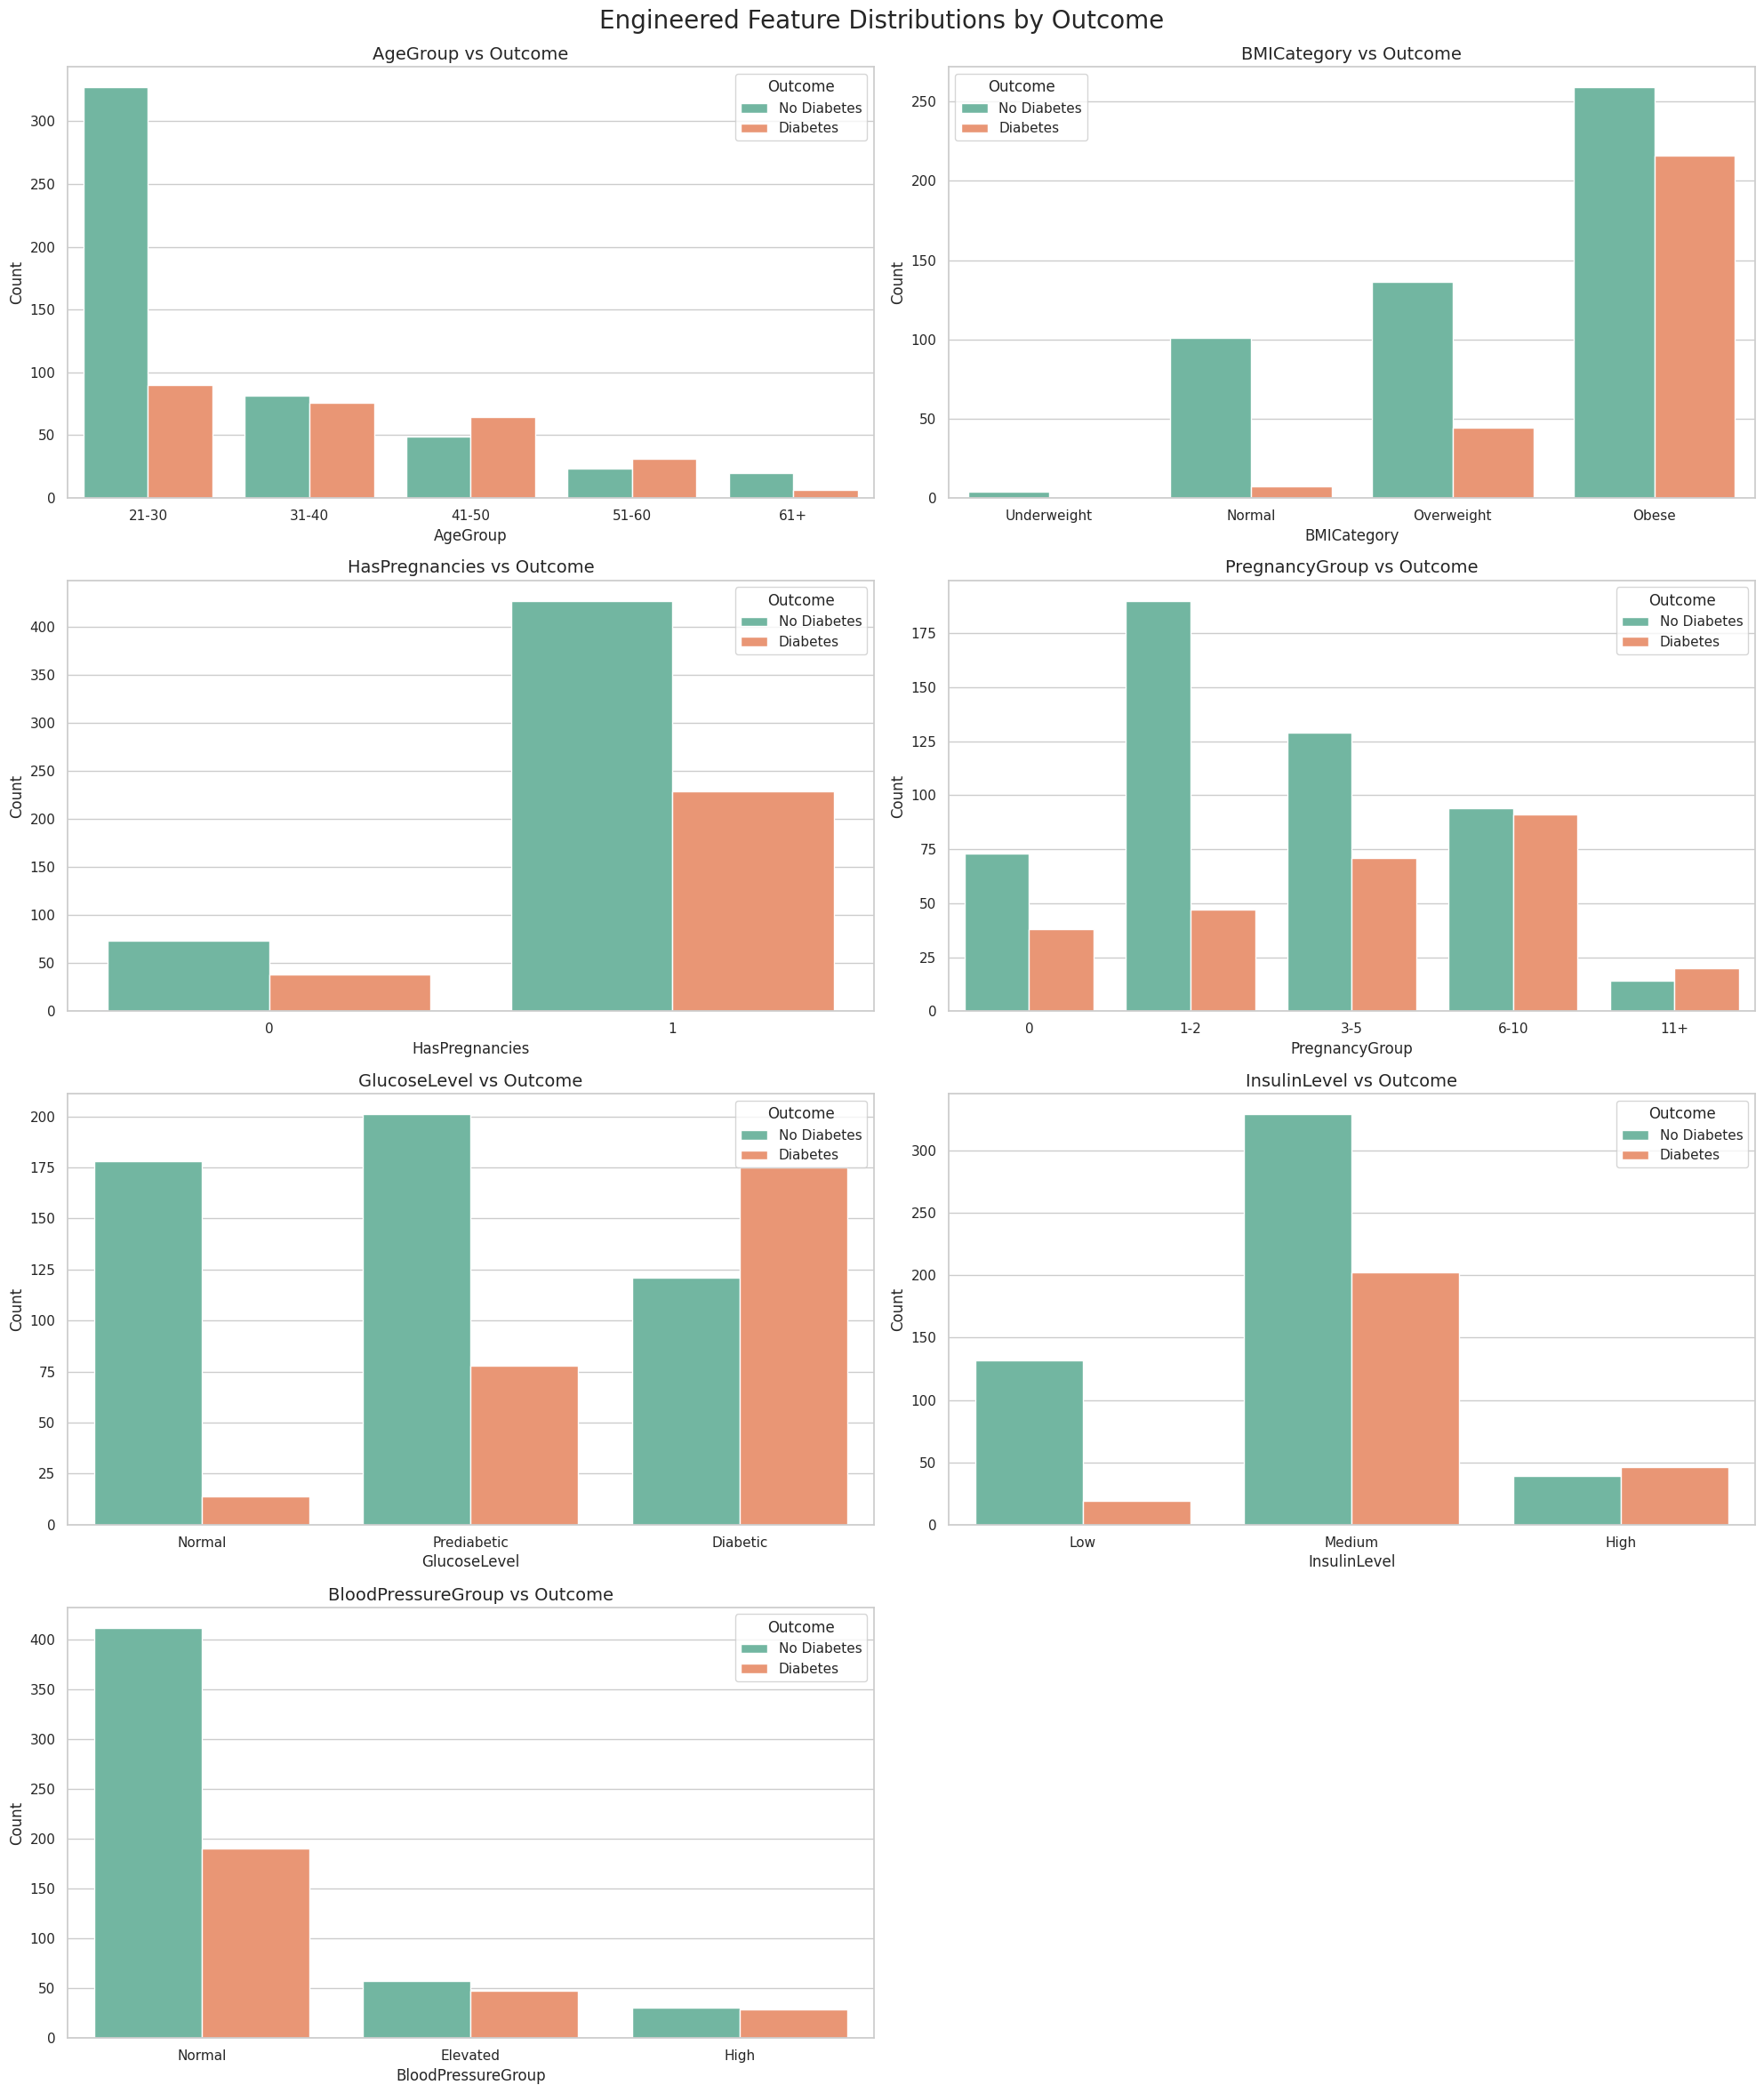

In [ ]:
sns.set(style="whitegrid")

# Features to plot
plot_features = ['AgeGroup', 'BMICategory', 'HasPregnancies',
                 'PregnancyGroup', 'GlucoseLevel', 'InsulinLevel', 'BloodPressureGroup']

# Create 4x2 grid (only use 7 plots)
fig, ax = plt.subplots(4, 2, figsize=(20, 24))
axes = ax.flatten()

for i, feature in enumerate(plot_features):
    sns.countplot(data=df, x=feature, hue='Outcome', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature} vs Outcome', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])

# Remove the unused subplot
fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Engineered Feature Distributions by Outcome', fontsize=20)
plt.show()

### Summary Insights from Engineered Feature Visualizations

- **AgeGroup**: There is a noticeable increase in diabetes cases with age. The 41–50 and 51–60 age groups show higher proportions of diabetes, as expected from clinical risk trends.

- **BMICategory**: Obesity correlates strongly with diabetes. Most diabetic patients fall into the “Overweight” and “Obese” categories, confirming BMI’s importance.

- **HasPregnancies**: Individuals with one or more pregnancies are more likely to be diabetic compared to those with none. However, this feature alone does not show a dramatic separation.

- **PregnancyGroup**: Higher pregnancy counts (e.g., 6–10 or 11+) are associated with an increased diabetes outcome rate, particularly in gestational diabetes risk.

- **GlucoseLevel**: As expected, a strong visual separation is seen — most diabetic patients fall in the “Diabetic” glucose range, validating this feature’s predictive power.

- **InsulinLevel**: High insulin levels occur more frequently among diabetic patients, although there’s some overlap. This may reflect insulin resistance patterns.

- **BloodPressureGroup**: Elevated and high BP levels are more prevalent among diabetic patients, but the separation is less distinct than with glucose or BMI.

> These insights confirm that several of the engineered features — especially **GlucoseLevel**, **BMICategory**, and **AgeGroup** — provide useful separation between outcomes. They should be retained for modeling.


## Feature Selection

We use domain knowledge and feature importance methods (ANOVA and Random Forest) to select relevant features. The selected features include clinical indicators like Glucose, BMI, Age, and engineered categorical flags.


In [ ]:
# Separate features and label
X = df_encoded.drop('Outcome', axis=1)
y = df_encoded['Outcome'].astype(int)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)

# Create DataFrame of feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA F-Score': selector.scores_
}).sort_values(by='ANOVA F-Score', ascending=False)

feature_scores.head(10)


,Feature,ANOVA F-Score
1,Glucose,242.926491
21,GlucoseLevel_Diabetic,149.712776
5,BMI,82.415594
15,BMICategory_Obese,67.879633
13,BMICategory_Normal,47.067006
7,Age,44.798513
0,Pregnancies,40.105013
16,PregnancyGroup_1-2,35.390929
3,SkinThickness,35.219922
4,Insulin,33.343419


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ANOVA F-Score'].plot(kind='hist', bins=20, title='ANOVA F-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='ANOVA F-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['ANOVA F-Score'].plot(kind='line', figsize=(8, 4), title='ANOVA F-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

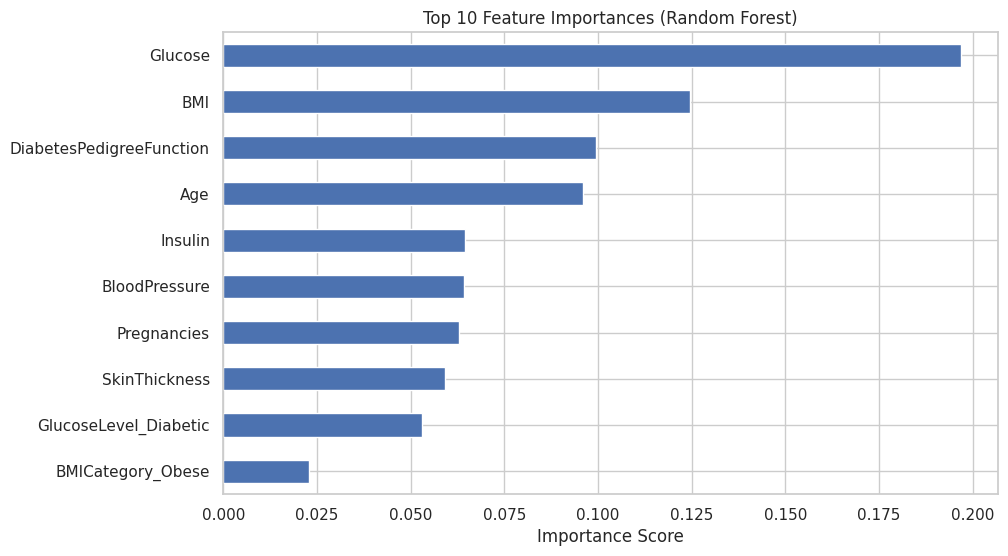

In [ ]:
# Train a simple model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


## Model Training and Evaluation

We evaluate six classification models:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)
- Decision Tree
- XGBoost

Performance is evaluated using accuracy, precision, recall, F1-score, and ROC AUC.


In [ ]:
# Final feature set based on feature selection methods
final_features = [
    'Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction',
    'Insulin', 'BloodPressure', 'Pregnancies', 'SkinThickness',
    'GlucoseLevel_Diabetic', 'BMICategory_Obese'
]

X_all = df_encoded.drop(columns='Outcome')      # All features
X_selected = df_encoded[final_features]         # Selected features
y = df_encoded['Outcome']


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),  # No class_weight support
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=1.87)
}

def evaluate_models(X, y, feature_label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=20
    )

    results = []
    trained_models = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba),
            'Feature Set': feature_label
        })

        trained_models[name] = model

    return pd.DataFrame(results), trained_models

## Model Performance Comparison

The table below shows the performance of each model on the test set. We evaluate both the full feature set and a selected subset.


In [ ]:
results_all, models_all = evaluate_models(X_all, y, 'All Features')
results_selected, models_selected = evaluate_models(X_selected, y, 'Selected Features')
comparison_df = pd.concat([results_all, results_selected], ignore_index=True)

comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Feature Set
0,Logistic Regression,0.811688,0.698413,0.814815,0.752137,0.885370,All Features
1,Random Forest,0.785714,0.783784,0.537037,0.637363,0.850833,All Features
2,SVM,0.759740,0.626866,0.777778,0.694215,0.869815,All Features
3,KNN,0.766234,0.673077,0.648148,0.660377,0.810185,All Features
4,Decision Tree,0.707792,0.581818,0.592593,0.587156,0.681296,All Features
5,XGBoost,0.727273,0.611111,0.611111,0.611111,0.816852,All Features
6,Logistic Regression,0.805195,0.693548,0.796296,0.741379,0.880000,Selected Features
7,Random Forest,0.779221,0.777778,0.518519,0.622222,0.849722,Selected Features
8,SVM,0.753247,0.617647,0.777778,0.688525,0.868981,Selected Features
9,KNN,0.766234,0.673077,0.648148,0.660377,0.812593,Selected Features


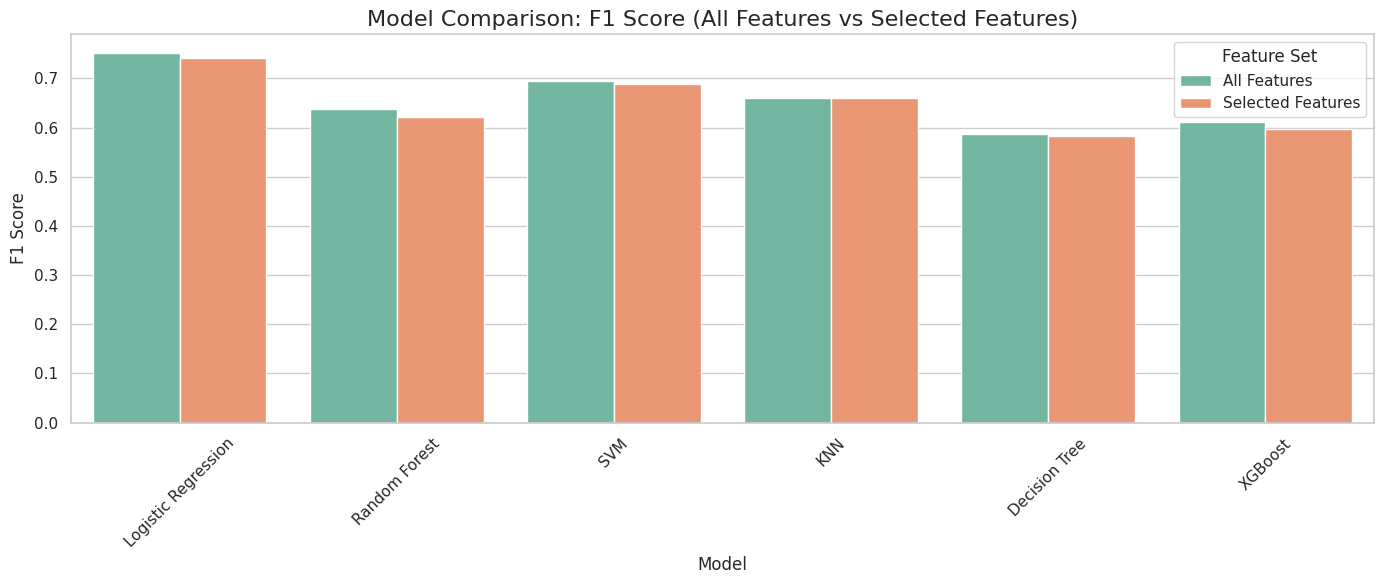

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=comparison_df, x='Model', y='F1 Score', hue='Feature Set', palette='Set2')
plt.title('Model Comparison: F1 Score (All Features vs Selected Features)', fontsize=16)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Feature Set')
plt.tight_layout()
plt.show()


## Classification Performance


### ROC Curve and Confusion Matrix

To better understand the classification behavior of our top models, we visualize:
- ROC curves for top 3 models
- Confusion matrices to analyze false positives/negatives


In [ ]:
top_3 = results_selected.sort_values('ROC AUC', ascending=False).head(3)
top_models_names = top_3['Model'].tolist()
top_models_selected = {name: models_selected[name] for name in top_models_names}

print(top_models_selected)

{'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000), 'SVM': SVC(class_weight='balanced', probability=True, random_state=42), 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)}


In [ ]:
def plot_roc_curves(models_dict, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Top 3 Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

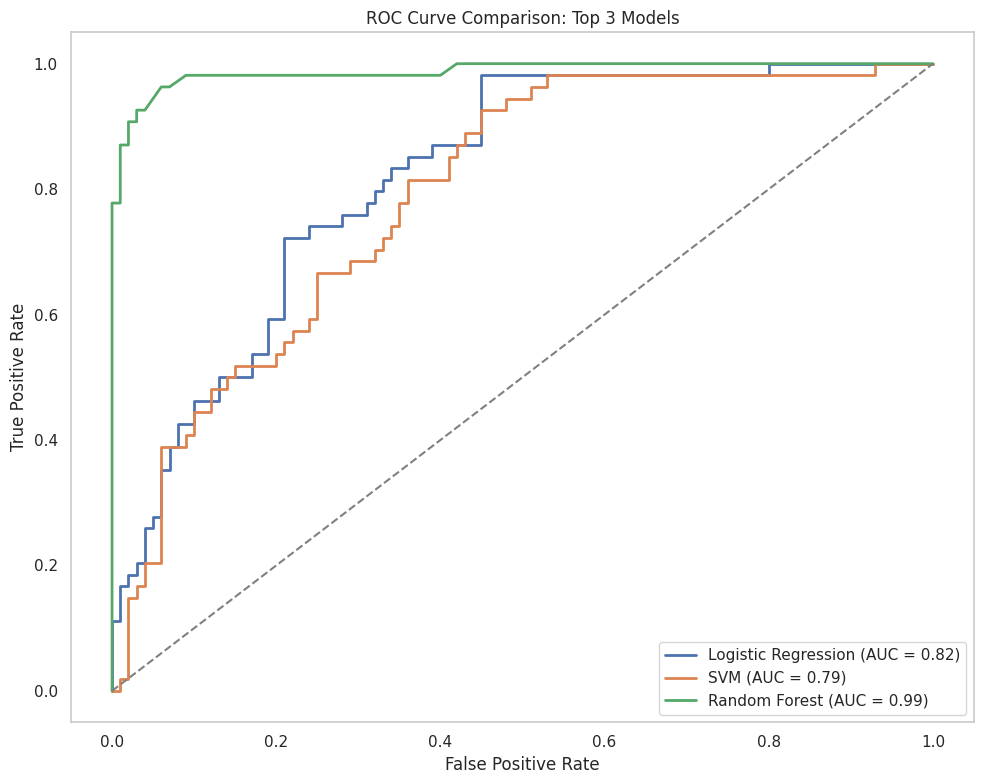

In [ ]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

plot_roc_curves(top_models_selected, X_test_sel, y_test_sel)


### Confusion Matrix


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_for_models(models_dict, X_test, y_test):
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
        plt.grid(False)
        plt.show()


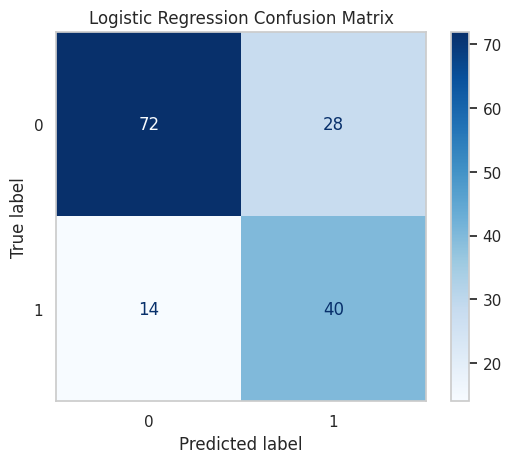

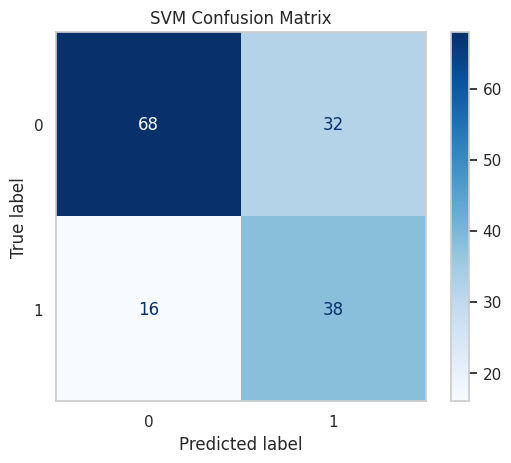

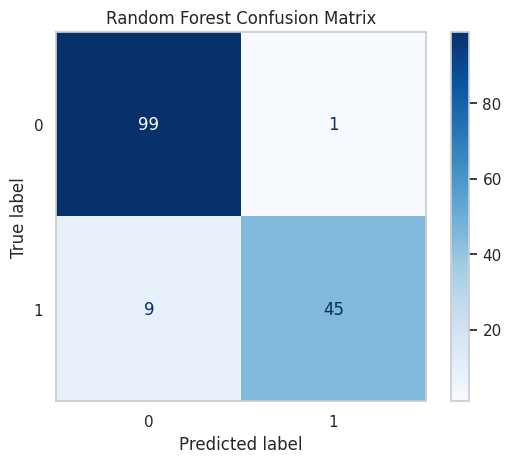

In [ ]:
plot_confusion_matrix_for_models(top_models_selected, X_test_sel, y_test_sel)


### SHAP Model Interpretability

We use SHAP (SHapley Additive Explanations) to interpret our Random Forest model's predictions.

- The bar chart shows which features have the highest overall contribution.
- The waterfall plot explains individual predictions, breaking down the final score by feature.


In [ ]:
import shap

# Use training set from selected features
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# Get best model
rf_model = models_selected['Random Forest']

# Create TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sel)


<Figure size 640x480 with 0 Axes>

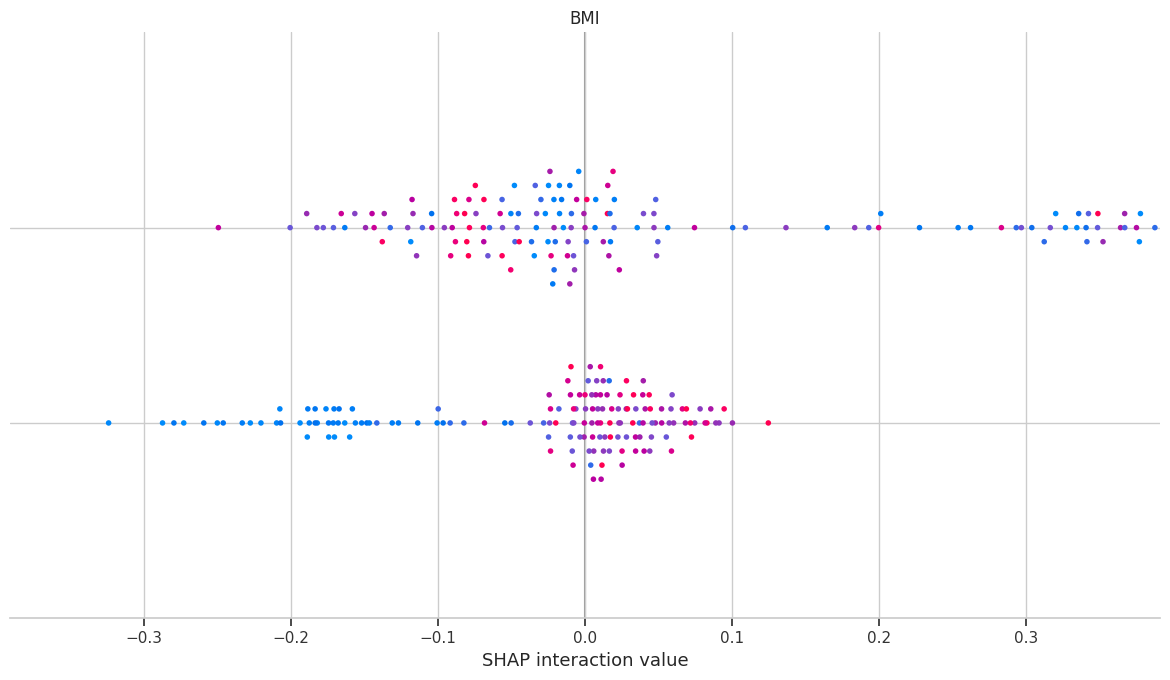

In [ ]:
# If it's a binary classification model, use shap_values[1]
shap_values_rf = shap_values[1] if isinstance(shap_values, list) else shap_values
shap.summary_plot(shap_values_rf, X_test_sel, plot_type='bar')


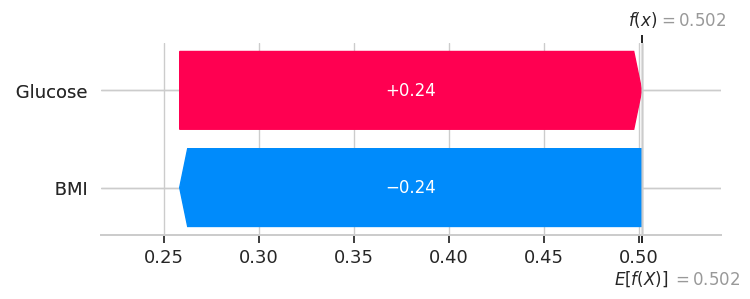

In [ ]:
# Optional: explain a single patient (e.g., first row)
shap.initjs()
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1], shap_values[1][0], X_test_sel.iloc[0]
)


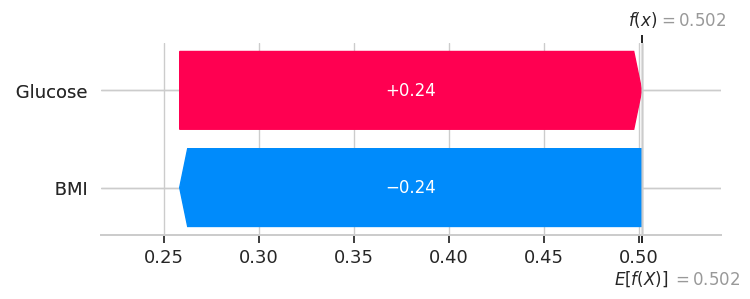

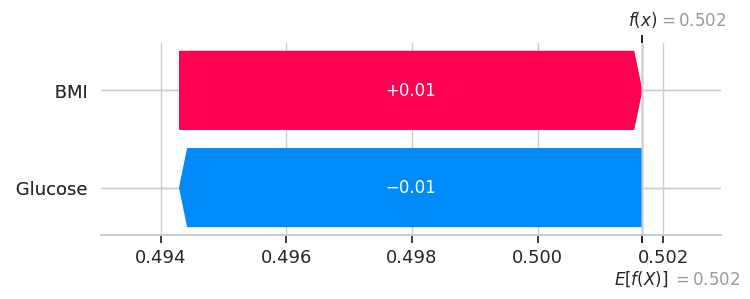

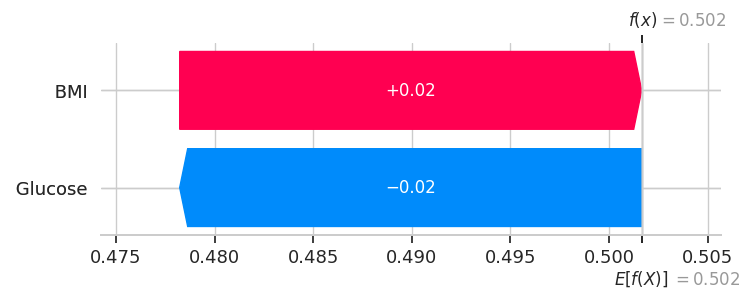

In [ ]:
# Explain multiple predictions (First 3 rows)
for i in range(3):
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[1], shap_values[1][i], X_test_sel.iloc[i]
    )


# Import models
Import the top 3 best performing models for prediction.


In [ ]:
import joblib

# Export top 3 models
joblib.dump(models['Logistic Regression'], 'logistic_regression_model.pkl')
joblib.dump(models['Random Forest'], 'random_forest_model.pkl')
joblib.dump(models['SVM'], 'svm_model.pkl')


['svm_model.pkl']